Conjunto de datos accesible desde la url: https://cocodataset.org/#explore

In [2]:
#@title mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'detectron2' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [32]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import PIL

# Creamos el modelo base de Detectron2.

In [6]:
!wget http://farm3.staticflickr.com/2797/4290631215_24308814f1_z.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

In [7]:
cfg = get_cfg()
# agregue la configuración específica del proyecto (por ejemplo, TensorMask) aquí si no está ejecutando un modelo en la biblioteca central de detectron2
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # establecer umbral para este modelo
# Encuentre un modelo del zoológico de modelos de detectron2. También puede usar la URL https://dl.fbaipublicfiles...
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[05/31 21:31:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
# mira las salidas. Consulte https://detectron2.readthedocs.io/tutorials/models.html#model-output-format para conocer las especificaciones
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0,  0, 31, 31], device='cuda:0')
Boxes(tensor([[170.8433, 206.7875, 294.7206, 347.9163],
        [546.4100,  77.7036, 625.9097, 249.3143],
        [425.3412,  70.9486, 503.0265, 203.5382],
        [511.6227, 227.9223, 635.0884, 251.7829],
        [262.4861, 331.7312, 299.1526, 354.5360]], device='cuda:0'))


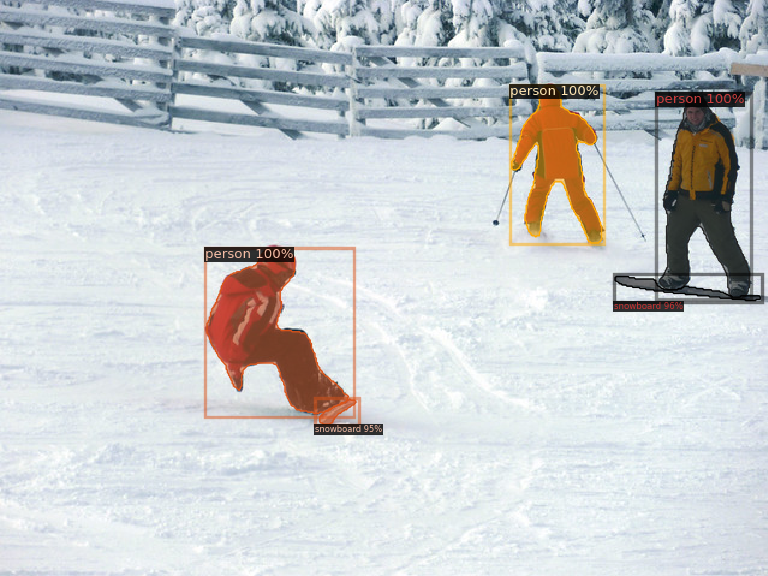

In [9]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
def detectarCoordenadas(imagen):
  """
  Esta función recibe el nombre de una imagen y realiza las siguientes operaciones:
  - Carga la imagen desde la carpeta correspondiente.
  - Configura la configuración del modelo usando la configuración del archivo YAML del modelo preentrenado.
  - Establece un umbral de puntuación para el modelo.
  - Obtiene un modelo del zoo de modelos de detectron2.
  - Utiliza el modelo para realizar predicciones en la imagen.
  - Extrae las clases predichas y las coordenadas de las instancias detectadas.
  - Devuelve la imagen original, la matriz de clases y la matriz de coordenadas.

  Args:
      imagen (str): El nombre de la imagen a procesar.

  Returns:
      array: La imagen original.
      array: La matriz de clases.
      array: La matriz de coordenadas.
  """
  # Cargar la imagen desde la carpeta correspondiente.
  im = cv2.imread(f'/content/{imagen}')
  cfg = get_cfg() # Cargar la imagen desde la carpeta correspondiente.
  # Agregar la configuración específica del proyecto (por ejemplo, TensorMask) aquí si no estás ejecutando un modelo en la biblioteca central de detectron2
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # establecer umbral para este modelo
  # Encontrar un modelo del zoo de modelos de detectron2.
  # También se puede usar una URL específica en caso de tener un modelo personalizado.
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
  predictor = DefaultPredictor(cfg)
  # Utilizar el modelo para realizar predicciones en la imagen
  outputs = predictor(im)
  # Extraer las clases predichas y las coordenadas de las instancias detectadas
  output_clase = outputs["instances"].pred_classes
  clase = output_clase.cpu().numpy()

  output_pred_boxes = outputs["instances"].pred_boxes
  coordenadas = output_pred_boxes.tensor.cpu().numpy()
  
  return im, clase, coordenadas
  

In [46]:
  # Cargar la imagen desde la carpeta correspondiente.
  im = cv2.imread(f'/content/2436675517_6ec9c59581_z.jpg')
  cfg = get_cfg() # Cargar la imagen desde la carpeta correspondiente.
  # Agregar la configuración específica del proyecto (por ejemplo, TensorMask) aquí si no estás ejecutando un modelo en la biblioteca central de detectron2
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # establecer umbral para este modelo
  # Encontrar un modelo del zoo de modelos de detectron2.
  # También se puede usar una URL específica en caso de tener un modelo personalizado.
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
  predictor = DefaultPredictor(cfg)
  # Utilizar el modelo para realizar predicciones en la imagen
  outputs = predictor(im)
  # Extraer las clases predichas y las coordenadas de las instancias detectadas
  output_clase = outputs["instances"].pred_classes
  clase = output_clase.cpu().numpy()

  output_pred_boxes = outputs["instances"].pred_boxes
  coordenadas = output_pred_boxes.tensor.cpu().numpy()
  
  #return im, clase, coordenadas

[05/31 21:55:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [15]:
clase[0]

36

In [ ]:
imagen,clase,coordenada = detectarCoordenadas('2436675517_6ec9c59581_z.jpg')

In [17]:
def removerFondo(imagen,clase,coordenada):
  """
    Esta función recibe una imagen, una matriz de clases y una matriz de coordenadas, y realiza las siguientes operaciones:
    - Identifica el índice de la clase 31 en la matriz de clases.
    - Si no se encuentra ningún objeto con clase 31, muestra un mensaje de error y finaliza el programa.
    - Si se encuentra un objeto con clase 31, obtiene las coordenadas correspondientes y calcula el centro del objeto.
    - Si hay varios objetos con clase 31, busca el objeto con el área máxima y obtiene sus coordenadas y centro.
    - Recorta la imagen utilizando las coordenadas del objeto y devuelve el recorte resultante.

    Args:
        imagen (array): La imagen original.
        clase (array): La matriz de clases.
        coordenada (array): La matriz de coordenadas.

    Returns:
        array: El recorte de la imagen correspondiente al objeto identificado.

    """
  # Identificar los índices de los objetos con clase 31
  class_1_indices = np.where(clase == 31)[0]

  if len(class_1_indices) == 0:
    # Identificar los índices de los objetos con clase 31
    print("No se identifico ningun objeto")
    exit()

  if len(class_1_indices) == 31:
    # Si solo hay un objeto con clase 31, obtener sus coordenadas y calcular el centro del objeto.
    coord_idx = class_1_indices[0]
    coord = coordenada[coord_idx]
    x_top_left = coord[0]
    y_top_left = coord[1]
    x_bottom_right = coord[2]
    y_bottom_right = coord[3]
    x_center = (x_top_left + x_bottom_right) / 2
    y_center = (y_top_left + y_bottom_right) / 2
  
  else:
    # Si hay varios objetos con clase 31, encontrar el objeto con el área máxima y obtener sus coordenadas y centro.
    max_area = 0
    max_area_idx = None
    for idx in class_1_indices:
        coord = coordenada[idx]
        area = (coord[2] - coord[0]) * (coord[3] - coord[1])
        if area > max_area:
            max_area = area
            max_area_idx = idx
    coord = coordenada[max_area_idx]
    x_top_left = coord[0]
    y_top_left = coord[1]
    x_bottom_right = coord[2]
    y_bottom_right = coord[3]
    x_center = (x_top_left + x_bottom_right) / 2
    y_center = (y_top_left + y_bottom_right) / 2

  # Si hay varios objetos con clase 31, encontrar el objeto con el área máxima y obtener sus coordenadas y centro.
  recorte = im[int(y_top_left):int(y_bottom_right), int(x_top_left):int(x_bottom_right)]
  return recorte

In [26]:
class_1_indices = clase[0]
class_= np.where(clase == 36)[0]
class_

array([0])

In [47]:
# Identificar los índices de los objetos con clase 31
class_1_indices = np.where(clase == 36)[0]

if len(class_1_indices) == 0:
  # Identificar los índices de los objetos con clase 31
  print("No se identifico ningun objeto")
  exit()

if len(class_1_indices) == 36:
  # Si solo hay un objeto con clase 31, obtener sus coordenadas y calcular el centro del objeto.
  coord_idx = class_1_indices[0]
  coord = coordenada[coord_idx]
  x_top_left = coord[0]
  y_top_left = coord[1]
  x_bottom_right = coord[2]
  y_bottom_right = coord[3]
  x_center = (x_top_left + x_bottom_right) / 2
  y_center = (y_top_left + y_bottom_right) / 2

else:
  # Si hay varios objetos con clase 31, encontrar el objeto con el área máxima y obtener sus coordenadas y centro.
  max_area = 0
  max_area_idx = None
  for idx in class_1_indices:
      coord = coordenadas[idx]
      area = (coord[2] - coord[0]) * (coord[3] - coord[1])
      if area > max_area:
          max_area = area
          max_area_idx = idx
  coord = coordenadas[max_area_idx]
  x_top_left = coord[0]
  y_top_left = coord[1]
  x_bottom_right = coord[2]
  y_bottom_right = coord[3]
  x_center = (x_top_left + x_bottom_right) / 2
  y_center = (y_top_left + y_bottom_right) / 2

# Si hay varios objetos con clase 31, encontrar el objeto con el área máxima y obtener sus coordenadas y centro.
recorte = im[int(y_top_left):int(y_bottom_right), int(x_top_left):int(x_bottom_right)]

In [48]:
recorte

array([[[12, 38, 22],
        [14, 37, 22],
        [14, 37, 22],
        ...,
        [14, 28, 17],
        [18, 29, 19],
        [21, 32, 22]],

       [[ 7, 30, 15],
        [13, 36, 21],
        [25, 46, 31],
        ...,
        [20, 34, 23],
        [23, 34, 24],
        [22, 33, 23]],

       [[ 1,  8,  3],
        [ 6,  6,  6],
        [ 1,  1,  1],
        ...,
        [22, 41, 38],
        [14, 31, 28],
        [17, 29, 23]],

       ...,

       [[ 9, 21, 15],
        [ 7, 21, 15],
        [ 9, 23, 17],
        ...,
        [19, 32, 16],
        [18, 32, 14],
        [15, 28, 12]],

       [[ 8, 20, 14],
        [ 5, 19, 13],
        [ 5, 19, 13],
        ...,
        [10, 25, 11],
        [11, 27, 10],
        [11, 26, 12]],

       [[ 8, 20, 14],
        [ 3, 17, 11],
        [ 4, 18, 12],
        ...,
        [13, 28, 14],
        [14, 29, 15],
        [13, 28, 14]]], dtype=uint8)

In [ ]:
  # Convertir el recorte en una imagen utilizando la función `fromarray` de la biblioteca PIL.
  im = Image.fromarray(recorte)
  # Generar un nombre de archivo utilizando la representación en cadena de la imagen.
  file_name=f"{im}"
  # Generar un nombre de archivo utilizando la representación en cadena de la imagen.
  #imPath = "/content/drive/MyDrive/6to semestre/Computer Vision/1er Parcial/data/Recortes_Imagenes"
  imPath = "/content/drive/MyDrive/6to semestre/Computer Vision/1er Parcial/data/Recortes_Imagenes"
  # Generar un nombre de archivo utilizando la representación en cadena de la imagen.
  im = im.save(f"{imPath}/{file_name}") 

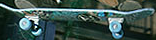

In [49]:
im = Image.fromarray(recorte)
im

In [50]:
from PIL import Image

# Supongamos que 'recorte' es tu matriz de imagen en numpy

# Crear una instancia de la imagen utilizando la matriz de recorte
im = Image.fromarray(recorte)
im
# Generar un nombre de archivo utilizando la representación en cadena de la imagen.
file_name = "nombre_de_archivo.jpg"  # Cambia el nombre del archivo según tus necesidades

# Guardar la imagen en el directorio especificado
imPath = "/content/drive/MyDrive/6to semestre/Computer Vision/1er Parcial/data/Recortes_Imagenes"  # Cambia la ruta según tus necesidades
im.save(f"{imPath}/{file_name}")

In [ ]:
def guardarImagenRecortada(recorte):
  # Convertir el recorte en una imagen utilizando la función `fromarray` de la biblioteca PIL.
  im = im.fromarray(recorte)
  # Generar un nombre de archivo utilizando la representación en cadena de la imagen.
  file_name=f"{im}"
  # Generar un nombre de archivo utilizando la representación en cadena de la imagen.
  #imPath = "/content/drive/MyDrive/6to semestre/Computer Vision/1er Parcial/data/Recortes_Imagenes"
  imPath = "/content/drive/MyDrive/Imagenes/Recortes_Imagenes"
  # Generar un nombre de archivo utilizando la representación en cadena de la imagen.
  im = im.save(f"{imPath}/{file_name}")   
  

In [ ]:
import os
# Utiliza la función os.walk() para recorrer los archivos en el directorio y subdirectorios especificados
# 'dirname' es el nombre del directorio actual, '_' son las carpetas que no se van a utilizar y 
#'filenames' son los nombres de archivo en la carpeta actual
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Imagenes'):
    # Itera sobre cada nombre de archivo en la lista 'filenames' de la carpeta actual
    for filename in filenames:
      # Imprime la ruta de acceso completa del archivo actual
      im, clase, coordenada = detectarCoordenadas(filename)
      recorte = removerFondo(im, clase, coordenada)
      guardarImagenRecortada(recorte)
      print(f'Imagen guardada con exito: {filename}')
        #print(os.path.join(dirname, filename))

[05/31 18:31:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
No se identifico ningun objeto


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


IndexError: ignored